# Why do we not want kids?

Exploring the connection between education and kids: Does the length of a woman's education, affect the amount of kids, that she gets?

To explore the relationship, we use data from Statistikbanken, on fertility and education. The fertility is illustrated using the fertility quotient which is live births per 1,000 women in the fertile age groups (15-49). The education is illustrated as the population with a higher education. 


To conduct the analysis, we have used data from Statistikbanken.dk on the fertility quotient and population with a longer education in different municipalities. Specifically; Thisted, Aalborg and Copenhagen. 

First, we explore the datasets by plotting the total development in education in the three municipalities. Notably, the plot shows a significant increase in all three cities. 

Next, we want to explore, is there could be a link between having a longer education and the number of kids women give birth to. This is done by, plotting the total amount of people with a higher education against the fertility quotient in the three municipalities. The plots indicate, that there is a link between the two.

To find out, if it is the urban or the rural areas that drive the change in recent years. We have calculated the percentage of the population in each municipality with a higher education. From the results we can see, that the fertility quotient in Thhisted has seen the biggest decline in recent years, even though all municipalities have had a rather large increase in the percent of people with a higher education. We can therefore conclude, that as the rural areas start to get longer education, we will see a large effect on the fertility quotient. 


 In the analysis, we compare our findings to other countries, using data from Eurostat. From this we can conclude, that the trend is also happening in other countries. 

To run our code, you have to install the DST API wrapper and Pandas-datareader

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns



# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# The DST API wrapper
%pip install git+https://github.com/alemartinello/dstapi

# A wrapper for multiple APIs with a pandas interface
%pip install pandas-datareader

# User written modules
import dataproject

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

import warnings
warnings.filterwarnings('ignore')


  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/12/264rh1fs0qdgby4_yjl2rst40000gn/T/pip-req-build-yq2sylps
  Running command git clone --filter=blob:none --quiet https://github.com/alemartinello/dstapi /private/var/folders/12/264rh1fs0qdgby4_yjl2rst40000gn/T/pip-req-build-yq2sylps
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Reading and cleaning data

We have installed a CSV files from DST, that includes data regarding the education in denmark among the population.

In [2]:
#Load the data from Statistik Banken
ind = DstApi('HFUDD11')


Cleaning the data

In [3]:
# Table of HFUD11 cleaned
from dataproject import HFUD11_data

processed_data = HFUD11_data()
processed_data.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,highereducation
2,Aalborg,2008,9481
5,Aalborg,2009,9953
8,Aalborg,2010,10469
11,Aalborg,2011,10993
14,Aalborg,2012,11719
17,Aalborg,2013,12276
20,Aalborg,2014,12806
23,Aalborg,2015,13724
26,Aalborg,2016,14781
29,Aalborg,2017,15501


The table above shows, how many people of all ages and ethnicities in Denmark, have a higher education in Aalborg, Thisted, and Copenhagen and years. We have chosen the three municipalities to get a differentiated perspective on the numbers. Thisted represents rural municipalities, where people do not have much education. Copenhagen is the capital of Denmark, where the highly educated and ambitious often prefer to live. Aalborg is a mix between Thisted and Copenhagen since it is the third biggest city in Denmark but located in the Nothern Jutland.

We have installed a CSV files from DST, that includes data regarding the fertility quotient in denmark among the population.

In [4]:
# Table of FOD407 cleaned
from dataproject import FOD407_data

fertility_data = FOD407_data()
fertility_data.head(10)

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00


,municipality,year,fertilityquotient
41,Aalborg,2006,1681.4
44,Aalborg,2007,1686.6
47,Aalborg,2008,1765.2
50,Aalborg,2009,1724.8
35,Aalborg,2010,1743.1
53,Aalborg,2011,1610.9
38,Aalborg,2012,1624.0
15,Aalborg,2013,1546.2
12,Aalborg,2014,1542.4
5,Aalborg,2015,1639.5


The tables shows the fertility i Aalborg, Copenhagen and Thisted across years in Denmark for women in all ages from 2006 to 2023.

## Exploring each data set

To explore our data sets, we make an interactive figure. The figure shows how many people have a higher education in the three regions, that we have chosen. 

In [5]:
# First we call our two cleaned tables
fert_api = FOD407_data()
ind_api = HFUD11_data()

Table FOD407: Fertility rates by region, age and time
Last update: 2024-02-12T08:00:00
Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


In [6]:
#First we define the function, that we are plotting
def plot_e(df, municipality): 
    #The boolean series returns true for rows, where the value in the municipality coloumn mtches the municipality parameter.
    I = df['municipality'] == municipality
    #df.loc[I:] filters the dataframe using the boolean series to include only those rowsa where the municipality matches.
    #year is set on the x-axis, BA is set as the y-axis,
    ax=df.loc[I,:].plot(x='year', y='highereducation', style='-o', legend=False)

    # Set the x-axis label
    years = df.loc[I, 'year'].unique()  # Get unique years
    ax.set_xticks(years)  # Set x-ticks to the unique years
    ax.set_xticklabels(years, rotation=45)  # Rotate labels for better visibility

    # Set the y-axis label
    ax.set_ylabel("Population with a highereducation")
    
    plt.show()


#Secondly, we make the widget interaction.
widgets.interact(plot_e, 
    #ind_api is fixed
    df = widgets.fixed(ind_api),
    #creates a dropdoen widget for selecting municipality. The default value is selected as Copenhagen. 
    municipality = widgets.Dropdown(description='Municipality', 
                                    options=ind_api.municipality.unique(), 
                                    value='Copenhagen')
); 


interactive(children=(Dropdown(description='Municipality', index=1, options=('Aalborg', 'Copenhagen', 'Thisted…

When changing the municipality we can see, that the amount of people with a higher education, has been increasing for all 3 cities since 2008. Copenhagen has the highest total amont of people with a higher education.

# Merge data sets

Before we merge the data sets, we check; that the years are the same in the datasets, and the dataset has information about the same municipalities. 

In [7]:
#We determine, if there is a difference in the years and municipalities in the two datasets, that we are using. 

#First for years
diff_y = [y for y in fert_api.year.unique() if y not in ind_api.year.unique()] 
print(f'years in fertility data, but not in education data: {diff_y}')


#Then for municipalities
diff_m = [m for m in fert_api.municipality.unique() if m not in ind_api.municipality.unique()] 
print(f'muncipalities in fertility data, but not in education data: {diff_m}')



years in fertility data, but not in education data: [2006, 2007]
muncipalities in fertility data, but not in education data: []


From the above we can see, that the dataset regarding fertility contains data from the years 2006 and 2007, that is not contained in the dataset about education.

Otherwise, the two datasets contains information about fertility and municiaplities in the same years. 

We are now going to merge the two datasets using the left merge method, so we don't get the years 2006 and 2007.

In [8]:
# We use the left merge method
# First, we merge the two datasets on both 'municipality' and 'year' using a left merge.
inner_with_area = pd.merge(ind_api, fert_api, on=['municipality', 'year'], how='left')

# Converting values to numeric types
inner_with_area['fertilitykvotient'] = pd.to_numeric(inner_with_area['fertilitykvotient'], errors='coerce')

# Displaying the dataframe
print(inner_with_area.head(10))

KeyError: 'fertilitykvotient'

The table above shows, how many people have a BA degree and the fertility kvotient in Aalborg, Thisted and Copenhagen.

# Analysis

To find a relationship between the fertility and amount of people with a higher education, we plot the development in fertility and education in the same coordinatsystem. 

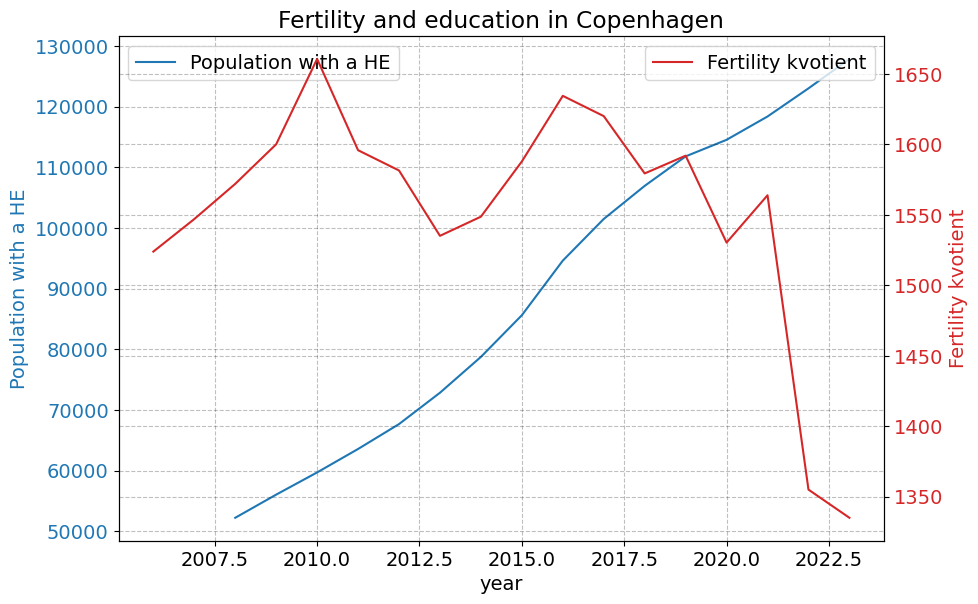

In [ ]:
from dataproject import plot_fer_HE_copenhagen

# Call the function to plot
plot_fer_HE_copenhagen(ind_api, fert_api)

From the table above, we can see, that the number of people with a BA has increased. Opposite the fertilitykvotient has decreased. 

From 2006-2020 the fertility seemed rather constant. However, it fell drastically in 2020. In the same period, the amount of people with a BA increased significantly compared to prior years. 

This could indicate, that when people take a longer education, they get fewer kids. 

We want to determine, if the same relationsship is evident in Thisted and Aalborg. 

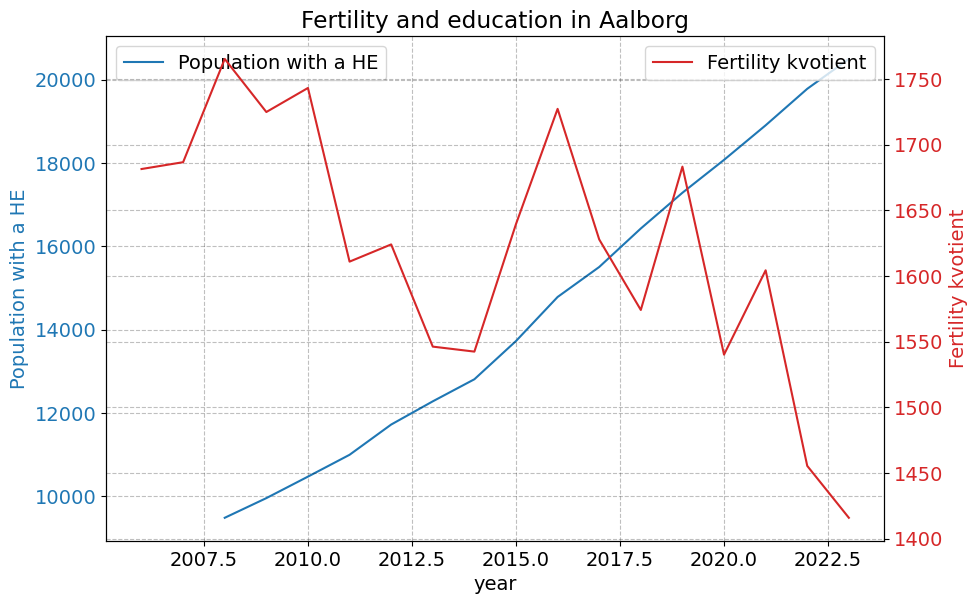

In [ ]:
#Plot for Aalborg

from dataproject import plot_fer_HE_aalborg

# Call the function to plot
plot_fer_HE_aalborg(ind_api, fert_api)

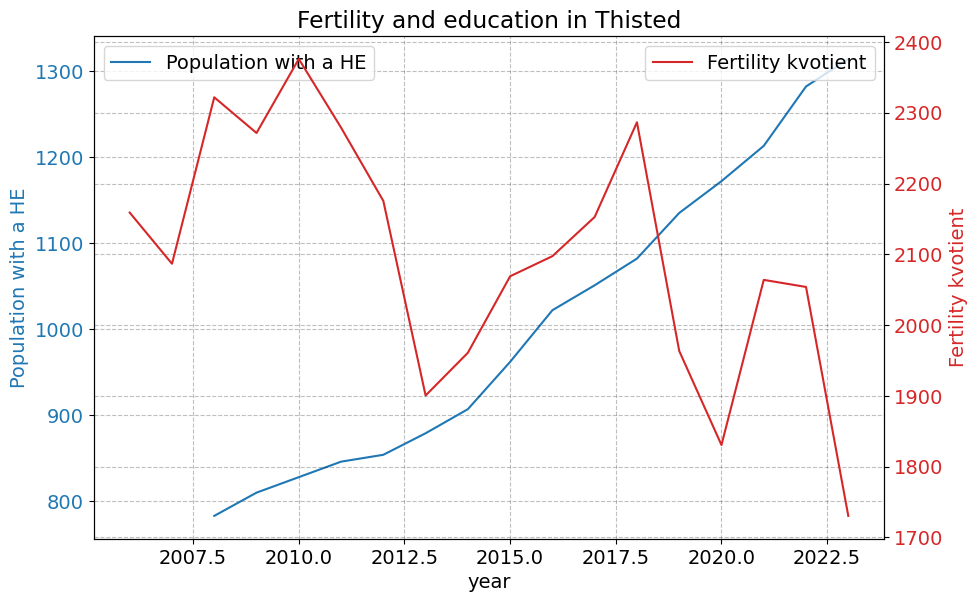

In [ ]:
#Plot for Thisted

from dataproject import plot_fer_HE_thisted

# Call the function to plot
plot_fer_HE_thisted(ind_api, fert_api)

The data from Thisted and Aalborg shows the same as Copenhagen. For the last years, people have been taking longer education, which might have led to a decrease in the fertilitykvotient. Especially in the last few years, the amount of people with a bachelor education has increased significantly and the fertilitykvotient has decreased a lot. 

# Education and fertility as a percent of the population in the areas

Using HFUDD11 to get a proxy of how many people who live in the areas

In [ ]:
# Table of HFUD11 cleaned
from dataproject import population_data

pop_data = population_data()
pop_data.head(10)

Table HFUDD11: Educational attainment (15-69 years) by region, ancestry, highest education completed, age, sex and time
Last update: 2024-04-12T08:00:00


,municipality,year,totalpop
2,Aalborg,2008,142461
5,Aalborg,2009,143297
8,Aalborg,2010,144662
11,Aalborg,2011,146765
14,Aalborg,2012,148482
17,Aalborg,2013,150456
20,Aalborg,2014,151679
23,Aalborg,2015,152973
26,Aalborg,2016,153843
29,Aalborg,2017,154137


In [ ]:
# Ensure 'year' and 'municipality' are strings in pop_data
pop_data['year'] = pop_data['year'].astype(str)
pop_data['municipality'] = pop_data['municipality'].astype(str)

# Ensure 'year' and 'municipality' are strings in inner_with_area
inner_with_area['year'] = inner_with_area['year'].astype(str)
inner_with_area['municipality'] = inner_with_area['municipality'].astype(str)

In [ ]:
# Perform the merge on 'municipality' and 'year'
merged_data = pd.merge(inner_with_area, pop_data, on=['municipality', 'year'], how='left')

# Display the merged dataframe
print(merged_data.head(10))

  municipality  year  highereducation  fertilitykvotient  totalpop
0      Aalborg  2008             9481             1765.2    142461
1      Aalborg  2009             9953             1724.8    143297
2      Aalborg  2010            10469             1743.1    144662
3      Aalborg  2011            10993             1610.9    146765
4      Aalborg  2012            11719             1624.0    148482
5      Aalborg  2013            12276             1546.2    150456
6      Aalborg  2014            12806             1542.4    151679
7      Aalborg  2015            13724             1639.5    152973
8      Aalborg  2016            14781             1727.2    153843
9      Aalborg  2017            15501             1627.8    154137


In [ ]:
# Calculate BA/totalpop and fertilitykvotient/totalpop
merged_data['HE_percentage'] = (merged_data['highereducation'] / merged_data['totalpop']) * 100


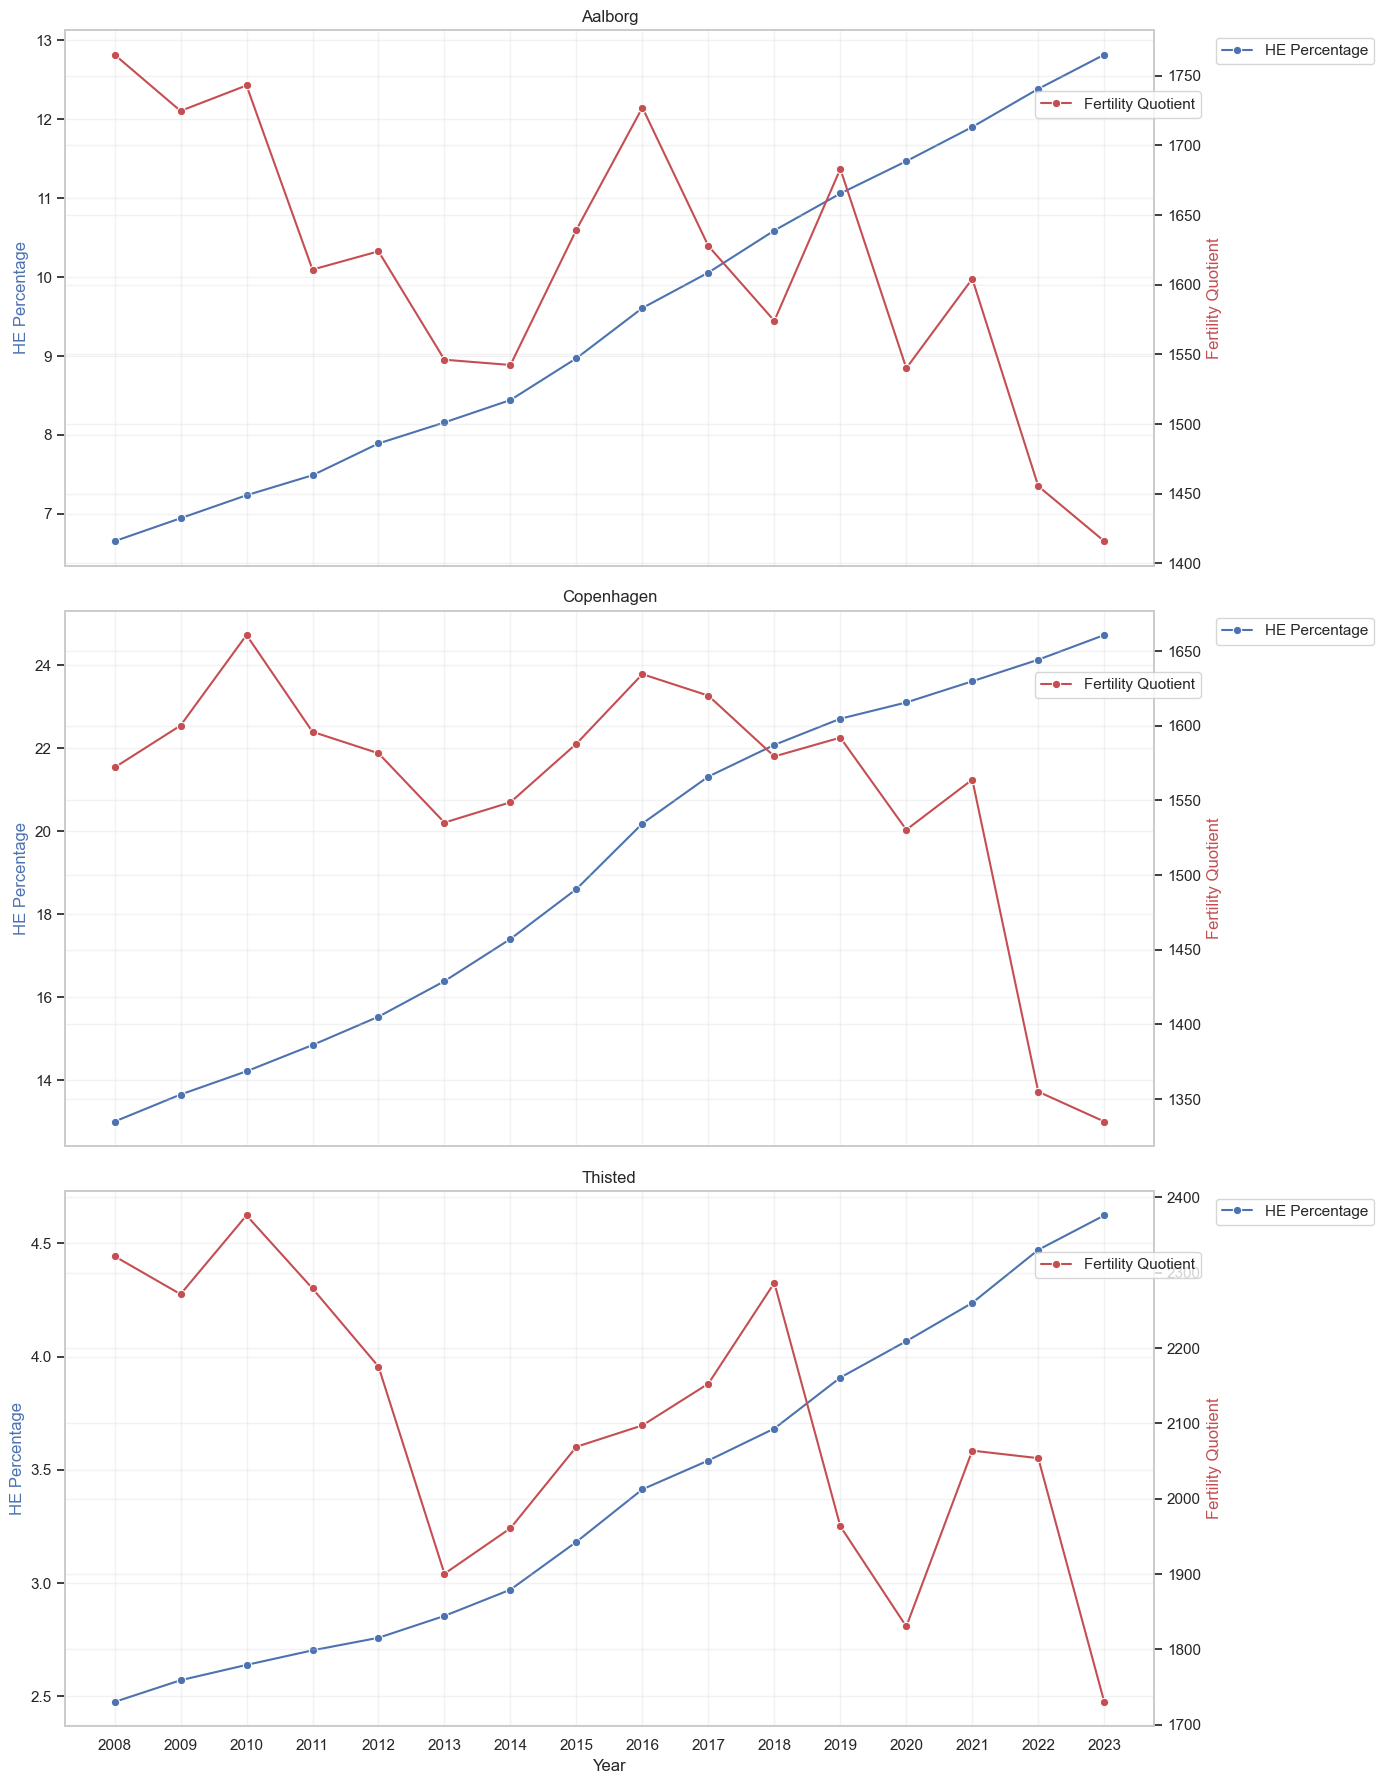

In [ ]:

# Filter data for each municipality
aalborg_data = merged_data[merged_data['municipality'] == 'Aalborg']
copenhagen_data = merged_data[merged_data['municipality'] == 'Copenhagen']
thisted_data = merged_data[merged_data['municipality'] == 'Thisted']

# Style of the plot
sns.set(style="whitegrid")

# Create a figure and axis objects for the plots
fig, axes = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot for Aalborg
ax1 = axes[0]
ax2 = ax1.twinx()
sns.lineplot(data=aalborg_data, x='year', y='HE_percentage', marker='o', ax=ax1, label='HE Percentage', color='b')
sns.lineplot(data=aalborg_data, x='year', y='fertilitykvotient', marker='o', ax=ax2, label='Fertility Quotient', color='r')
ax1.set_title('Aalborg')
ax1.set_ylabel('HE Percentage', color='b')
ax2.set_ylabel('Fertility Quotient', color='r')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9))

# Plot for Copenhagen
ax1 = axes[1]
ax2 = ax1.twinx()
sns.lineplot(data=copenhagen_data, x='year', y='HE_percentage', marker='o', ax=ax1, label='HE Percentage', color='b')
sns.lineplot(data=copenhagen_data, x='year', y='fertilitykvotient', marker='o', ax=ax2, label='Fertility Quotient', color='r')
ax1.set_title('Copenhagen')
ax1.set_ylabel('HE Percentage', color='b')
ax2.set_ylabel('Fertility Quotient', color='r')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9))

# Plot for Thisted
ax1 = axes[2]
ax2 = ax1.twinx()
sns.lineplot(data=thisted_data, x='year', y='HE_percentage', marker='o', ax=ax1, label='HE Percentage', color='b')
sns.lineplot(data=thisted_data, x='year', y='fertilitykvotient', marker='o', ax=ax2, label='Fertility Quotient', color='r')
ax1.set_title('Thisted')
ax1.set_ylabel('HE Percentage', color='b')
ax2.set_ylabel('Fertility Quotient', color='r')
ax1.set_xlabel('Year')
ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9))

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

From the above we can see, that the fertilitykvotient has seen the biggest decline in Thisted. Thisted also saw the biggest increase in the percent of people with a higher education, increasing from 2.5% to almost 5%. It is therefore indicated, that higher education in the rural areas, drives the big decline in the fertility quotient. 

# Other Countries

We now want to analyze, if the observations above, is also evident in other countries:

First, we clean the data for education across contries

In [ ]:
from dataproject import educ_c
# Display the cleaned DataFrame after removing columns
print("\nEducation DataFrame after removing columns 1-7 and column 11:")
educ_c = educ_c()
educ_c.head(5)


Education DataFrame after removing columns 1-7 and column 11:


,Country,Years,% tertiary educ.
0,AUT,2011,20.9
1,AUT,2012,22.8
2,AUT,2013,24.9
3,AUT,2014,38.4
4,AUT,2015,38.6


Now we pivot the dataset to show education levels grouped by country codes

In [ ]:
#Sorting Education data
# Check for duplicates in the 'geo' column
duplicates = educ_c['Country'].duplicated()


# Sort and index the dataframe by the years (2011-2021) for each country
educ_sorted = educ_c.set_index('Country').sort_index(axis=1).reset_index()


# Pivot the sorted DataFrame to show indicator values for each country
educ_pivoted = educ_sorted.pivot_table(index='Years', columns='Country', values='% tertiary educ.', aggfunc='first')

# Display the pivoted table showing the percentage of the total population for ages 25-34 with a tertiary education level
print("\nPivoted table showing indicator values of education for each country:")
educ_pivoted.head(5)


Pivoted table showing indicator values of education for each country:


Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,ESP,EST,...,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE,UK
Years,,,,,,,,,,,,,,,,,,,,,
2011,20.9,42.5,27.2,38.0,50.5,25.1,27.6,38.6,40.3,39.0,...,40.0,46.1,39.0,27.5,22.5,22.0,25.5,33.8,42.8,43.8
2012,22.8,43.0,27.2,39.3,53.6,27.8,28.9,40.2,40.4,40.1,...,41.4,45.0,40.8,29.0,23.6,24.9,27.0,35.3,43.5,45.1
2013,24.9,42.7,29.6,41.9,51.4,29.2,29.9,40.9,41.1,40.6,...,43.0,46.7,41.8,30.0,24.4,25.1,29.7,37.4,44.9,45.2
2014,38.4,44.2,31.3,44.2,54.0,29.9,28.4,41.6,41.5,40.6,...,44.3,50.2,42.6,31.4,25.4,27.1,29.8,38.0,46.0,45.8
2015,38.6,43.1,31.8,46.5,54.7,31.0,29.6,43.0,41.0,38.5,...,45.1,49.0,43.2,33.1,25.5,29.8,31.3,40.8,46.5,46.9


Then we do the same for fertility across countries

In [ ]:
from dataproject import fert
fert = fert()
fert.head(5)

,Country,Years,Fertility
0,AUT,2011,1.43
1,AUT,2012,1.44
2,AUT,2013,1.44
3,AUT,2014,1.46
4,AUT,2015,1.49


In [ ]:
# Check for duplicates in the 'Country' column
duplicates = fert['Country'].duplicated()


# Sort and index the dataframe by the years (2011-2021) for each country
fert_sorted = fert.set_index('Country').sort_index(axis=1).reset_index()

# Pivot the sorted DataFrame to show indicator values for each country
fert_pivoted = fert_sorted.pivot_table(index='Years', columns='Country', values='Fertility', aggfunc='first')

# Display the pivoted table showing Fertility rates
print("\nPivoted table showing fertility values for each country:")
fert_pivoted.head(5)


Pivoted table showing fertility values for each country:


Country,AUT,BEL,BGR,CHE,CYP,CZE,DEU,DNK,ESP,EST,...,MNE,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
Years,,,,,,,,,,,,,,,,,,,,,
2011,1.43,1.81,1.51,1.52,1.360,1.43,1.39,1.75,1.34,1.61,...,1.65,1.76,1.88,1.33,1.35,1.47,1.40,1.45,1.56,1.90
2012,1.44,1.80,1.50,1.52,1.386,1.45,1.41,1.73,1.32,1.56,...,1.72,1.72,1.85,1.33,1.28,1.52,1.45,1.34,1.58,1.91
2013,1.44,1.76,1.48,1.52,1.305,1.46,1.42,1.67,1.27,1.52,...,1.73,1.68,1.78,1.29,1.21,1.46,1.43,1.34,1.55,1.89
2014,1.46,1.74,1.53,1.54,1.315,1.53,1.47,1.69,1.32,1.54,...,1.75,1.71,1.75,1.32,1.23,1.56,1.46,1.37,1.58,1.88
2015,1.49,1.70,1.53,1.54,1.326,1.57,1.50,1.71,1.33,1.58,...,1.74,1.66,1.72,1.32,1.31,1.62,1.46,1.40,1.57,1.85


We merge the two dataset:

In [ ]:
# Perform the merge on 'Country' and 'Years' columns between educ_sorted and fert_sorted DataFrames
merged = pd.merge(educ_sorted, fert_sorted, on=['Country', 'Years'], how='left')


# Assign the 'Fertility' series from the 'fert_sorted_ to 'merged' DataFrame
merged['Fertility'] = pd.to_numeric(fert_sorted['Fertility'], errors='coerce')

# Rearrange columns in desired order
merged = merged[['Country', 'Years', 'Fertility', '% tertiary educ.']]

# Merge the two pivoted tables on the index
merged_pivoted = pd.merge(fert_pivoted, educ_pivoted, left_index=True, right_index=True, suffixes=('_Fertility', '_% tertiary educ.'))

# Display the merged DataFrame showing both values side by side for each country
merged_pivoted.head(11)

Country,AUT_Fertility,BEL_Fertility,BGR_Fertility,CHE_Fertility,CYP_Fertility,CZE_Fertility,DEU_Fertility,DNK_Fertility,ESP_Fertility,EST_Fertility,...,NLD_% tertiary educ.,NOR_% tertiary educ.,POL_% tertiary educ.,PRT_% tertiary educ.,ROU_% tertiary educ.,SRB_% tertiary educ.,SVK_% tertiary educ.,SVN_% tertiary educ.,SWE_% tertiary educ.,UK
Years,,,,,,,,,,,,,,,,,,,,,
2011,1.43,1.81,1.51,1.52,1.360,1.43,1.39,1.75,1.34,1.61,...,40.0,46.1,39.0,27.5,22.5,22.0,25.5,33.8,42.8,43.8
2012,1.44,1.80,1.50,1.52,1.386,1.45,1.41,1.73,1.32,1.56,...,41.4,45.0,40.8,29.0,23.6,24.9,27.0,35.3,43.5,45.1
2013,1.44,1.76,1.48,1.52,1.305,1.46,1.42,1.67,1.27,1.52,...,43.0,46.7,41.8,30.0,24.4,25.1,29.7,37.4,44.9,45.2
2014,1.46,1.74,1.53,1.54,1.315,1.53,1.47,1.69,1.32,1.54,...,44.3,50.2,42.6,31.4,25.4,27.1,29.8,38.0,46.0,45.8
2015,1.49,1.70,1.53,1.54,1.326,1.57,1.50,1.71,1.33,1.58,...,45.1,49.0,43.2,33.1,25.5,29.8,31.3,40.8,46.5,46.9
2016,1.53,1.68,1.54,1.54,1.360,1.63,1.60,1.79,1.34,1.60,...,45.2,49.2,43.5,35.0,24.8,31.4,33.4,43.0,47.3,47.1
2017,1.52,1.65,1.56,1.52,1.322,1.69,1.57,1.75,1.31,1.59,...,46.6,48.3,43.6,34.0,25.6,32.2,35.1,44.5,47.4,47.2
2018,1.47,1.62,1.56,1.52,1.320,1.71,1.57,1.73,1.26,1.67,...,47.6,48.5,43.5,35.1,24.9,32.8,37.2,40.7,47.6,48.1
2019,1.46,1.60,1.58,1.48,1.332,1.71,1.54,1.70,1.23,1.66,...,49.1,48.4,43.5,37.4,25.5,33.4,39.2,44.1,48.4,49.4


Testing if the datasets contain the same information

In [ ]:
print(f'Years in education data: {educ_sorted.Years.unique()}')
print(f'country in education data = {len(educ_sorted.Country.unique())}')
print(f'Years in fertility data: {fert_sorted.Years.unique()}')
print(f'country in fertility data = {len(fert_sorted.Country.unique())}')

diff_y = [y for y in fert_sorted.Years.unique() if y not in educ_sorted.Years.unique()] 
print(f'years in fertility data, but not in education data: {diff_y}')

diff_m = [m for m in fert_sorted.Country.unique() if m not in educ_sorted.Country.unique()] 
print(f'countries in fertility data, but missing data points in education data: {diff_m}')

Years in education data: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
country in education data = 34
Years in fertility data: [2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
country in fertility data = 34
years in fertility data, but not in education data: []
countries in fertility data, but missing data points in education data: ['GBR']


We know plot a graph of three different countries within the EU. Note that the country codes can be changed to compare other countries. In our example below, we have chosen Denmark (DNK), Romania (ROU) and Italy (ITA).

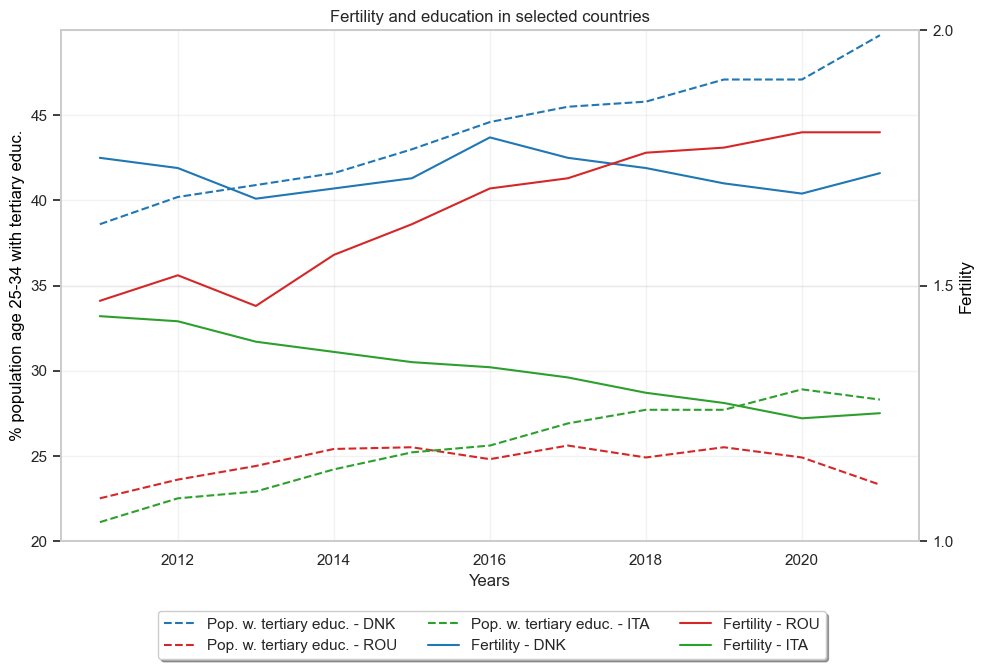

In [ ]:
import matplotlib.pyplot as plt

#Plot

from dataproject import plot_fertility_education_country

# List of up to 3 country codes to compare
country_codes = ['DNK', 'ROU', 'ITA']

# Call the function to plot
plot_fertility_education_country(educ_sorted, fert_sorted, country_codes)



From the graph above we can conclude, that the trend seen in Denmark with longer education and decreasing fertility is the same across other countries.

# Conclusion

From our analysis we can conclude that there might be a negative relationship between longer educations and fertility. However, we can only speak of a correlation, and not so much as to the causation. Other factors such as economic development, social norms and religious impact may have an affect on the fertility, as well as the prevalence of birth control. The project could be expanded to countries that vary from those of the EU, e.g. Sub-Saharan nations or South-East Asian nations to gain insight on the correlation with respect to nations with varying social structures.